In [ ]:
#Importing libraries

import tensorflow as tf 
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import zipfile 
import os 
import cv2 
import numpy as np 
import pickle 
import random
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
from keras.utils import np_utils
from keras_preprocessing.image import ImageDataGenerator
import glob
import matplotlib.image as mpimg
import seaborn as sns

The colab is linked to the drive using drive.mount so that it is easy to access zip file of the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Loading the dataset from the drive and extracting in the /tmp directory

In [ ]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/ML_Project_006_012_017/Dataset.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()#Close the zip file


**DATA CLEANING**

**Remove Blurry Images**

**Training Dataset**

In [ ]:
import glob
my_list=[]
path = "/tmp/Dataset/train/*/*.jpg"
for file in glob.glob(path): #using glob for iteration
  

  a= cv2.imread(file) #reading file using imread
  my_list.append(a)
  # compute the Laplacian of the image and then return the focus
	# measure, which is simply the variance of the Laplacian
  laplacian_var = cv2.Laplacian(a, cv2.CV_64F).var()
  # if the focus measure is less than the supplied threshold,
	# then the image should be considered "blurry"
  if laplacian_var < 5:
    print("Image Blurry: " + file)
    os.remove(file)

**Validation Dataset**

In [ ]:

my_list=[]
path = "/tmp/Dataset/val/*/*.jpg"
for file in glob.glob(path): #using glob for iteration
  

  a= cv2.imread(file) #reading file using imread
  my_list.append(a)
  # compute the Laplacian of the image and then return the focus
	# measure, which is simply the variance of the Laplacian
  laplacian_var = cv2.Laplacian(a, cv2.CV_64F).var()
  # if the focus measure is less than the supplied threshold,
	# then the image should be considered "blurry"
  if laplacian_var < 5:
    print("Image Blurry: " + file)
    os.remove(file)

Image Blurry: /tmp/Dataset/val/plastic_bottles/00000201.jpg


**DESCRIPTIVE ANALYTICS**

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("/tmp/Dataset/")
class_names = dataset.class_names
class_names

Found 15366 files belonging to 2 classes.


['train', 'val']

Our dataset is divided into training and validation set

In [ ]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory("/tmp/Dataset/train/")
class_names_train = dataset_train.class_names
print(class_names_train)

dataset_val = tf.keras.preprocessing.image_dataset_from_directory("/tmp/Dataset/val/")
class_names_val = dataset_val.class_names
print(class_names_val)

Found 14165 files belonging to 8 classes.
['ewaste', 'food_waste', 'leaf_waste', 'metal_cans', 'paper_waste', 'plastic_bags', 'plastic_bottles', 'wood_waste']
Found 1201 files belonging to 8 classes.
['ewaste', 'food_waste', 'leaf_waste', 'metal_cans', 'paper_waste', 'plastic_bags', 'plastic_bottles', 'wood_waste']


The training set and validation set is further divided into biodegradable and non-biodegradable category

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/tmp/Dataset/train/",
    shuffle=True, #shuffling images
    image_size = (512,512), #resizing images
    batch_size = 32 #Dividing the images into batches
)

Found 14165 files belonging to 8 classes.


In [ ]:
#Displaying class names of each dataset
class_names = dataset.class_names
class_names

['ewaste',
 'food_waste',
 'leaf_waste',
 'metal_cans',
 'paper_waste',
 'plastic_bags',
 'plastic_bottles',
 'wood_waste']

In [ ]:
len(dataset) #This denotes the length of every batch
# 397*32=12704 
#This will not come exact as the dataset might be imbalanced

443

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)

(32, 512, 512, 3)


<Figure size 720x720 with 0 Axes>

(32,256,256,3)
This implies that our dataset is divided into 32 batches each and has fixed image size of (256x256) pixels. There are 3 channels denoted by rgb. Since the data has images, it can only be computed using a 3x3 matrix.

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    np_train = np.array(image_batch)
    print(image_batch[0].numpy())
    np_train_scaled = np_train/255 #normalizing the dataset between 0 and 1
    
# This shows how the dataset is divided into 3x3 matrix

[[[  0.      5.      0.   ]
  [  0.      5.      0.   ]
  [  0.      5.      0.   ]
  ...
  [  8.      7.      2.   ]
  [  7.      6.      2.   ]
  [  5.      4.      0.   ]]

 [[  0.      5.      0.   ]
  [  0.      5.      0.   ]
  [  0.      5.      0.   ]
  ...
  [  8.      7.      2.   ]
  [  7.      6.      2.   ]
  [  5.625   4.625   0.625]]

 [[  0.      5.      0.   ]
  [  0.      5.      0.   ]
  [  0.      5.      0.   ]
  ...
  [  8.375   7.375   2.375]
  [  7.375   6.375   2.375]
  [  6.75    5.75    1.75 ]]

 ...

 [[ 91.375 104.375 113.375]
  [ 92.    105.    114.   ]
  [ 93.    106.    115.   ]
  ...
  [180.375 186.625 191.875]
  [180.625 185.625 190.875]
  [180.    185.    190.25 ]]

 [[ 91.    104.    113.   ]
  [ 91.625 104.625 113.625]
  [ 92.625 105.625 114.625]
  ...
  [180.375 187.375 193.375]
  [181.375 186.375 192.375]
  [180.375 185.375 191.375]]

 [[ 91.    104.    113.   ]
  [ 91.    104.    113.   ]
  [ 92.    105.    114.   ]
  ...
  [181.    188.    194. 

<Figure size 720x720 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  print(np_train_scaled[0]) #Scaled Between 0 and 1

[[[0.         0.01960784 0.        ]
  [0.         0.01960784 0.        ]
  [0.         0.01960784 0.        ]
  ...
  [0.03137255 0.02745098 0.00784314]
  [0.02745098 0.02352941 0.00784314]
  [0.01960784 0.01568628 0.        ]]

 [[0.         0.01960784 0.        ]
  [0.         0.01960784 0.        ]
  [0.         0.01960784 0.        ]
  ...
  [0.03137255 0.02745098 0.00784314]
  [0.02745098 0.02352941 0.00784314]
  [0.02205882 0.01813726 0.00245098]]

 [[0.         0.01960784 0.        ]
  [0.         0.01960784 0.        ]
  [0.         0.01960784 0.        ]
  ...
  [0.03284314 0.02892157 0.00931373]
  [0.02892157 0.025      0.00931373]
  [0.02647059 0.02254902 0.00686275]]

 ...

 [[0.35833332 0.40931374 0.44460785]
  [0.36078432 0.4117647  0.44705883]
  [0.3647059  0.41568628 0.4509804 ]
  ...
  [0.70735294 0.7318627  0.752451  ]
  [0.7083333  0.72794116 0.74852943]
  [0.7058824  0.7254902  0.74607843]]

 [[0.35686275 0.40784314 0.44313726]
  [0.35931373 0.41029412 0.44558823]


<Figure size 720x720 with 0 Axes>

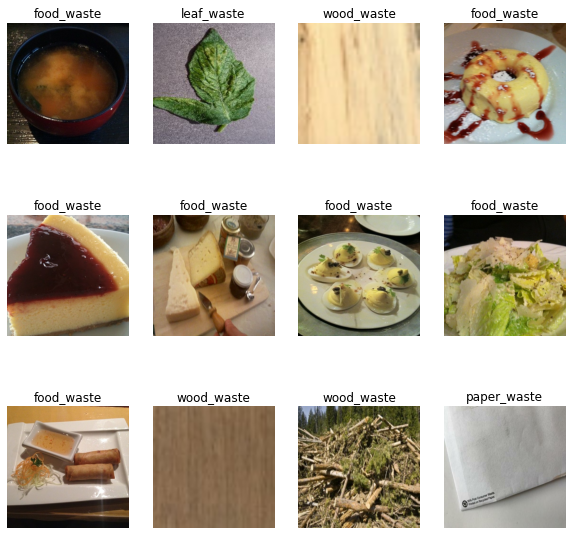

In [ ]:
#Plotting the dataset for a set of 12 images 
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1): #The take() function is used to return the elements in the given positional indices along an axis
  for i in range(12): # Displaying 12 images from first batch
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")
  

**DATA VISUALIZATION**

# **Bar and Pie Plot**


In [ ]:
train_path = "/tmp/Dataset/train/"
val_path = "/tmp/Dataset/val/"

In [ ]:
# for images in training dataset, we define a path for each of the classes using dictionary
train = {'food_waste': len(os.listdir(f'{train_path}/food_waste')),
'leaf_waste': len(os.listdir(f'{train_path}/leaf_waste')),
'paper_waste': len(os.listdir(f'{train_path}/paper_waste')),
'wood_waste': len(os.listdir(f'{train_path}/wood_waste')),
'ewaste': len(os.listdir(f'{train_path}/ewaste')),
'metal_cans': len(os.listdir(f'{train_path}/metal_cans')),
'plastic_bags': len(os.listdir(f'{train_path}/plastic_bags')),
'plastic_bottles': len(os.listdir(f'{train_path}/plastic_bottles')) 
}

In [ ]:
print(train.items())

dict_items([('food_waste', 10066), ('leaf_waste', 1179), ('paper_waste', 860), ('wood_waste', 593), ('ewaste', 180), ('metal_cans', 670), ('plastic_bags', 200), ('plastic_bottles', 417)])


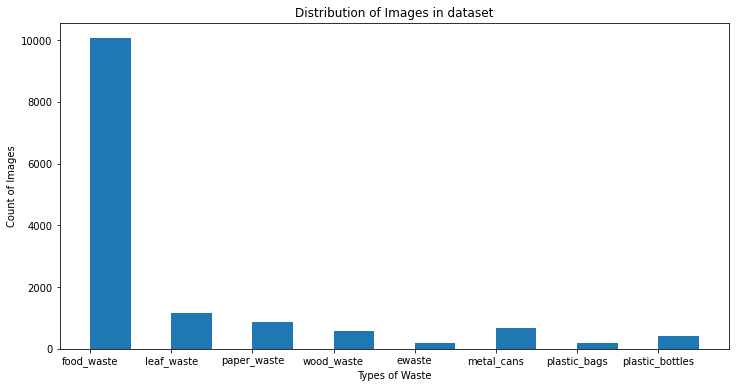

In [ ]:
#Plotting Bar Graph
plt.figure(figsize=(12, 6))  # width:12, height:6
plt.bar(train.keys(), train.values(), align='edge', width=0.5)
plt.title("Distribution of Images in dataset");
plt.xlabel('Types of Waste');
plt.ylabel('Count of Images');

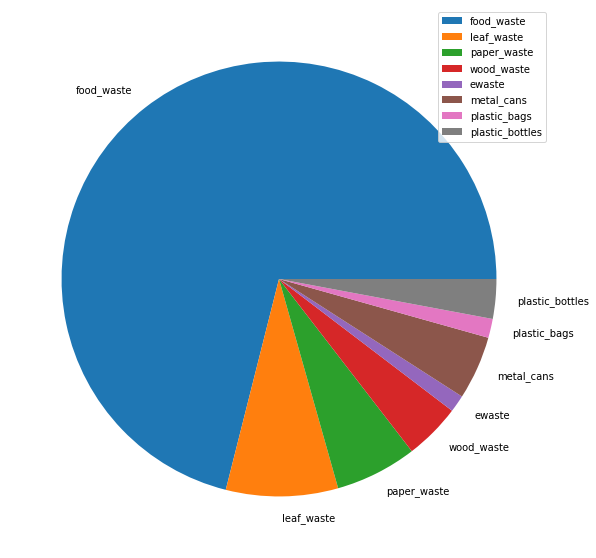

In [ ]:
plt.figure(figsize=(10,10))
plt.pie(train.values(), labels = train.keys())
plt.legend()
plt.show()

From the bar plot it can inferred that we have maximum number of food waste images around 10k followed by leaf waste, paper waste and wood waste for biodegradable waste whereas maximum images are from metal cans category that is around 680 followed by plastic bottles, plastic bags and then ewaste for non biodegradable waste

Repeating the above steps for validation dataset

In [ ]:
validation = {'food_waste': len(os.listdir(f'{val_path}/food_waste')),
'leaf_waste': len(os.listdir(f'{val_path}/leaf_waste')),
'paper_waste': len(os.listdir(f'{val_path}/paper_waste')),
'wood_waste': len(os.listdir(f'{val_path}/wood_waste')),
'ewaste': len(os.listdir(f'{val_path}/ewaste')),
'metal_cans': len(os.listdir(f'{val_path}/metal_cans')),
'plastic_bags': len(os.listdir(f'{val_path}/plastic_bags')),
'plastic_bottles': len(os.listdir(f'{val_path}/plastic_bottles'))       
}

In [ ]:
print(validation.items())

dict_items([('food_waste', 229), ('leaf_waste', 394), ('paper_waste', 212), ('wood_waste', 59), ('ewaste', 55), ('metal_cans', 69), ('plastic_bags', 53), ('plastic_bottles', 130)])


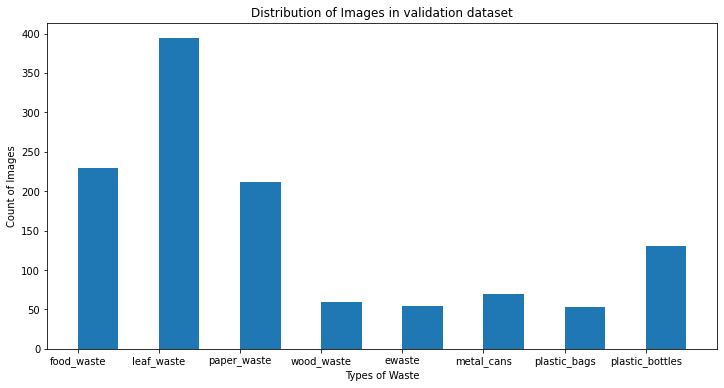

In [ ]:
#Plotting Bar Graph
plt.figure(figsize=(12, 6))  # width:20, height:3
plt.bar(validation.keys(), validation.values(), align='edge', width=0.5)
plt.title("Distribution of Images in validation dataset");
plt.xlabel('Types of Waste');
plt.ylabel('Count of Images');

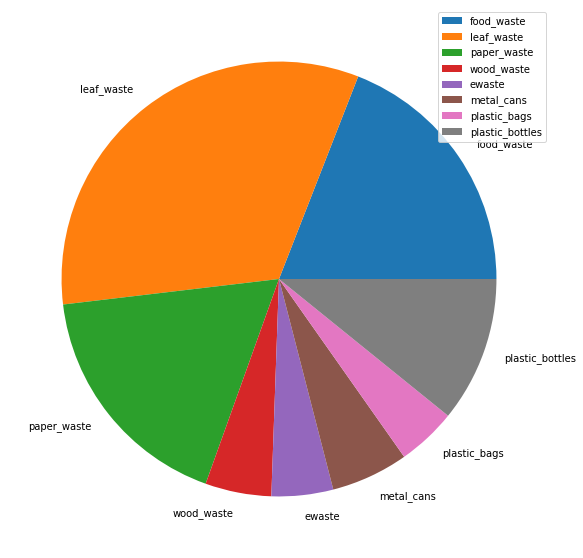

In [ ]:
plt.figure(figsize=(10,10))
plt.pie(validation.values(), labels = validation.keys())
plt.legend()
plt.show()

From the above plots, it can be inferred that we have maximumn number of leaf waste images around 400 in our dataset followed by food waste, paper waste and wood waste for biodegradable waste whereas  maximum images are from plastic waste category that is around 125 followed by metal cans, ewaste and then plastic bags in the validation dataset of non biodegradable waste.

**Visualization of Intensity distribution using histogram.**

*For grayscale image*

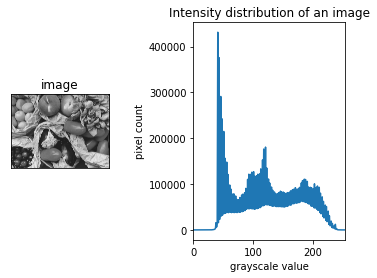

In [ ]:
#reading an image using cv2
path=r'/tmp/Dataset/train/food_waste/00000000.jpg'
img = cv2.imread(path,0)

#plotting the image
plt.subplot(1,3,1)
plt.imshow(img,cmap='gray')
plt.title('image')
plt.xticks([])
plt.yticks([])
#plotting the histogram
plt.subplot(1,2,2)
hist,bin = np.histogram(img.ravel(),256,[0,255])
plt.xlim([0,255])
plt.plot(hist)
plt.xlabel('grayscale value')
plt.ylabel('pixel count')
plt.title('Intensity distribution of an image')
plt.show()

*For colored Image*

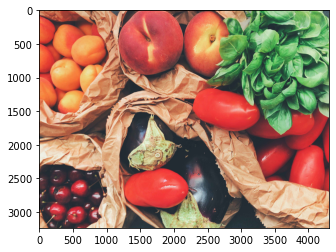

In [ ]:
# Read Images
img = mpimg.imread('/tmp/Dataset/train/food_waste/00000000.jpg')
 
# Output Images
plt.imshow(img)

In [ ]:
# Get RGB data from image
blue_color = cv2.calcHist([img], [0], None, [256], [0, 256])
red_color = cv2.calcHist([img], [1], None, [256], [0, 256])
green_color = cv2.calcHist([img], [2], None, [256], [0, 256])

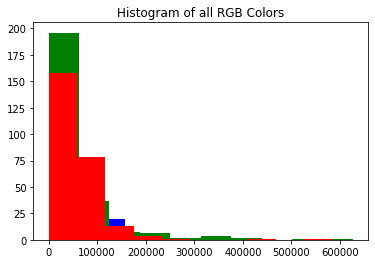

In [ ]:
#plotting the histogram.
plt.title("Histogram of all RGB Colors")
plt.hist(blue_color, color="blue")
plt.hist(green_color, color="green")
plt.hist(red_color, color="red")
plt.show()


**Data Augmentation**



Data Augmentation is used while training the data so as to avoid overfitting by adding sample of images which are flipped, rotated and zoomed.

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'), # It will randomly flips images while training in 
    layers.experimental.preprocessing.RandomRotation(0.2), #It will randomly rotate the images in 20% range
    layers.experimental.preprocessing.RandomZoom(0.3, 0.2), #It will randomly zoom images with an height and width factor of 30% and 20% respectively
  ]
)

## **TRAIN TEST SPLIT**

In [ ]:
#defining categories for each kind of waste
categories = ['ewaste',
 'metal_cans',
 'plastic_bottles',
'plastic_bags',
'food_waste',
'paper_waste',
'wood_waste',
'leaf_waste'
 ]

In [ ]:
data = []
dir = "/tmp/Dataset/train/"

In [ ]:
#dividing the images into features and labels category where labels will be the target column for training the model
for category in categories:
  path = os.path.join(dir,category)
  label = categories.index(category)

  for img in os.listdir(path):
    imgpath = os.path.join(path,img)
    waste_img = cv2.imread(imgpath,0)
    waste_img = cv2.resize(waste_img,(32,32))
    image = np.array(waste_img).flatten()

    data.append([image,label])

In [ ]:
print(len(data))

14165


In [ ]:
pick_in = open('data1.pickle','wb')
pickle.dump(data,pick_in)
pick_in.close()

In [ ]:
# import pickle
# from google.colab import drive
# drive.mount('/content/drive')
# DATA_PATH = "/content/"
# infile = open(DATA_PATH+'data1.pickle','rb')
# data = pickle.load(infile)

In [ ]:
#shuffling the features randomly
random.shuffle(data)
features = []
labels = []

In [ ]:
#adding data to the features and labels column
for feature, label in data:
  features.append(feature)
  labels.append(label)

In [ ]:
len(features)

14165

In [ ]:
#Splitting the data into training and testing
xtrain, xtest,ytrain,ytest = train_test_split(features, labels, test_size = 0.08)

In [ ]:
#Converting the data into array for easy computation
xtrain = np.array(xtrain, dtype=np.float32)
xtest = np.array(xtest, dtype=np.float32)

In [ ]:
#Applying min-max normalization to rescale the images between 0 and 1
xtrain=xtrain/255

In [ ]:
xtest=xtest/255

In [ ]:
len(xtrain)

13031

In [ ]:
#Resampling imbalanced data
from imblearn.combine import SMOTEENN  
sm = SMOTEENN()
X_resampled1, y_resampled1 = sm.fit_resample(features,labels)

In [ ]:
#Splitting into training and test sets
x_train,x_test,y_train,y_test=train_test_split(X_resampled1, y_resampled1,test_size=0.2)

## **Logistic Regression**

In [ ]:
logr = linear_model.LogisticRegression(max_iter=50000, multi_class='ovr')#for multi class we use ovr
logr.fit(xtrain,ytrain)

In [ ]:
prediction = logr.predict(xtest)

In [ ]:
accuracy_lr = logr.score(xtest,ytest)

In [ ]:
print('Accuracy: ', accuracy_lr)
print('Prediction: ', categories[prediction[0]])

In [ ]:
waste = xtest[0].reshape(128,128)
plt.imshow(waste,cmap='gray')
plt.show()

In [ ]:
from sklearn import metrics
print(metrics.classification_report(ytest, prediction))
import pandas as pd

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, prediction)

cm_df = pd.DataFrame(cm,
                     index = ["ewaste", "food_waste", "leaf_waste", "metal_cans", "paper_waste", "plastic_bags", "plastic_bottles", "wood_waste"], 
                     columns = ["ewaste", "food_waste", "leaf_waste", "metal_cans", "paper_waste", "plastic_bags", "plastic_bottles", "wood_waste"])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

## **Support Vector Classifier**

SVM chooses the extreme points/vectors that help in creating the hyperplane. These extreme cases are called as support vectors, and hence algorithm is termed as Support Vector Machine

In [ ]:
svm = SVC(C=1, kernel = 'poly', gamma = 'auto')

C: Regularization parameter,
kernel coefficient is defined as poly since we have multiclass classification
gamma is given default value as auto

In [ ]:
svm.fit(xtrain,ytrain)

SVC(C=1, gamma='auto', kernel='poly')

In [ ]:
prediction = svm.predict(xtest)

In [ ]:
accuracy = svm.score(xtest,ytest)

In [ ]:
print('Accuracy: ', accuracy)
print('Prediction: ', categories[prediction[0]])

Accuracy:  0.708994708994709
Prediction:  food_waste


Accuracy of SVC is 75% and it has classified the image correctly as food waste.

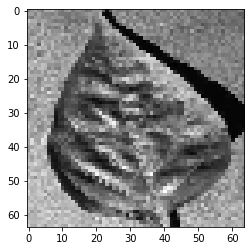

In [ ]:
waste = xtest[0].reshape(64,64)
plt.imshow(waste,cmap='gray')
plt.show()

In [ ]:
from sklearn import metrics
print(metrics.classification_report(ytest, prediction))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.71      0.09      0.16        54
           2       0.59      0.26      0.36        38
           3       0.00      0.00      0.00        22
           4       0.71      0.99      0.83       793
           5       0.00      0.00      0.00        67
           6       0.00      0.00      0.00        48
           7       0.00      0.00      0.00        98

    accuracy                           0.71      1134
   macro avg       0.25      0.17      0.17      1134
weighted avg       0.55      0.71      0.60      1134



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


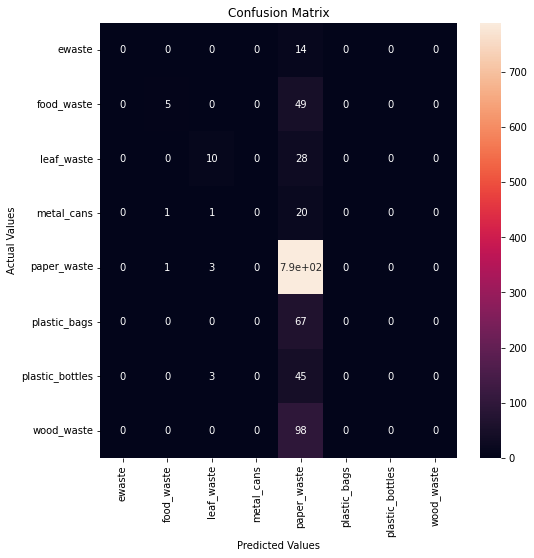

In [ ]:
cm = confusion_matrix(ytest, prediction)

cm_df = pd.DataFrame(cm,
                     index = ["ewaste", "food_waste", "leaf_waste", "metal_cans", "paper_waste", "plastic_bags", "plastic_bottles", "wood_waste"], 
                     columns = ["ewaste", "food_waste", "leaf_waste", "metal_cans", "paper_waste", "plastic_bags", "plastic_bottles", "wood_waste"])

#Plotting the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

**Naive Bayes**

Naive Bayes classifiers are a collection of classification algorithms based on Bayes’ Theorem. It is not a single algorithm but a family of algorithms where all of them share a common principle, i.e. every pair of features being classified is independent of each other.

In [ ]:
nb=GaussianNB()
nb.fit(xtrain,ytrain)

GaussianNB()

In [ ]:
prediction = nb.predict(xtest)
accuracy = nb.score(xtest,ytest)

In [ ]:
print('Accuracy: ', accuracy)
print('Prediction: ', categories[prediction[0]])

Accuracy:  0.37213403880070545
Prediction:  leaf_waste


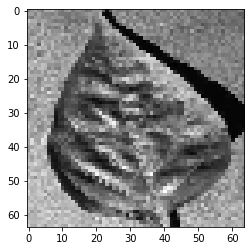

In [ ]:
waste = xtest[0].reshape(64,64)
plt.imshow(waste,cmap='gray')
plt.show()

              precision    recall  f1-score   support

           0       0.05      0.71      0.10        14
           1       0.27      0.43      0.33        54
           2       0.19      0.34      0.25        38
           3       0.00      0.00      0.00        22
           4       0.94      0.33      0.49       793
           5       0.30      0.52      0.38        67
           6       0.06      0.15      0.08        48
           7       0.34      0.76      0.47        98

    accuracy                           0.37      1134
   macro avg       0.27      0.40      0.26      1134
weighted avg       0.72      0.37      0.43      1134



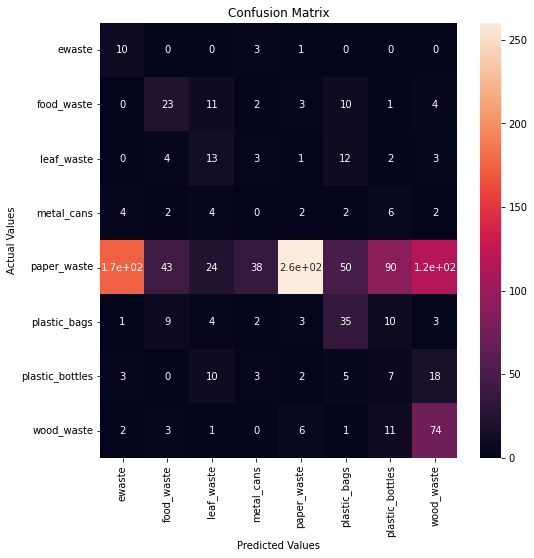

In [ ]:
from sklearn import metrics
print(metrics.classification_report(ytest, prediction))
import pandas as pd

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, prediction)

cm_df = pd.DataFrame(cm,
                     index = ["ewaste", "food_waste", "leaf_waste", "metal_cans", "paper_waste", "plastic_bags", "plastic_bottles", "wood_waste"], 
                     columns = ["ewaste", "food_waste", "leaf_waste", "metal_cans", "paper_waste", "plastic_bags", "plastic_bottles", "wood_waste"])

#Plotting the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

**K-Nearest Neighbours**

K-NN algorithm stores all the available data and classifies a new data point based on the similarity. This means when new data appears then it can be easily classified into a well suite category by using K- NN algorithm.

In [ ]:
knn=KNeighborsClassifier(n_neighbors=7,  metric='minkowski', p=2 )
knn.fit(xtrain,ytrain)

KNeighborsClassifier(n_neighbors=7)

Required neighbours of algorithm are taken as 7. 
metric='minkowski': This is the default parameter and it decides the distance between the points.
p=2: It is equivalent to the standard Euclidean metric.

In [ ]:
prediction = knn.predict(xtest)
accuracy = knn.score(xtest,ytest)

In [ ]:
print('Accuracy: ', accuracy)
print('Prediction: ', categories[prediction[0]])

Accuracy:  0.46119929453262787
Prediction:  wood_waste


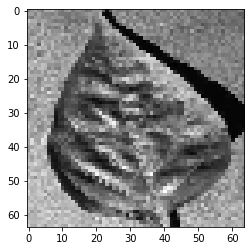

In [ ]:
waste = xtest[0].reshape(64,64)
plt.imshow(waste,cmap='gray')
plt.show()

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.38      0.41      0.39        54
           2       0.27      0.21      0.24        38
           3       0.04      0.05      0.04        22
           4       0.83      0.80      0.82       793
           5       0.30      0.37      0.33        67
           6       0.43      0.54      0.48        48
           7       0.51      0.50      0.50        98

    accuracy                           0.68      1134
   macro avg       0.34      0.36      0.35      1134
weighted avg       0.69      0.68      0.68      1134



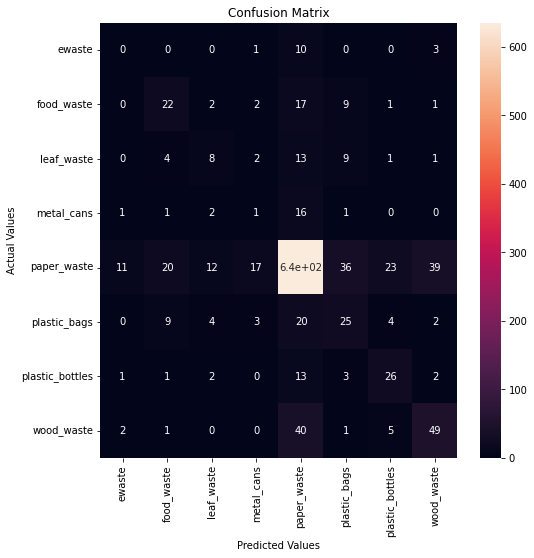

In [ ]:

print(metrics.classification_report(ytest, prediction))


from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, prediction)

cm_df = pd.DataFrame(cm,
                     index = ["ewaste", "food_waste", "leaf_waste", "metal_cans", "paper_waste", "plastic_bags", "plastic_bottles", "wood_waste"], 
                     columns = ["ewaste", "food_waste", "leaf_waste", "metal_cans", "paper_waste", "plastic_bags", "plastic_bottles", "wood_waste"])

#Plotting the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

## **Decision Tree Classifier**

It is a graphical representation for getting all the possible solutions to a problem/decision based on given conditions. It is called a decision tree because, similar to a tree, it starts with the root node, which expands on further branches and constructs a tree-like structure.

In [ ]:
dtc=DecisionTreeClassifier(criterion='entropy', random_state=7)
dtc.fit(xtrain,ytrain)

DecisionTreeClassifier(criterion='entropy', random_state=7)

"criterion='entropy': Criterion is used to measure the quality of split, which is calculated by information gain given by entropy.

In [ ]:
prediction = dtc.predict(xtest)
accuracy_dtc = dtc.score(xtest,ytest)

In [ ]:
print('Accuracy: ', accuracy_dtc)
print('Prediction: ', categories[prediction[0]])

Accuracy:  0.6754850088183422
Prediction:  food_waste


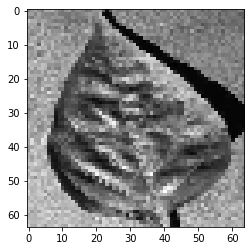

In [ ]:
waste = xtest[0].reshape(64,64)
plt.imshow(waste,cmap='gray')
plt.show()

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.38      0.41      0.39        54
           2       0.27      0.21      0.24        38
           3       0.04      0.05      0.04        22
           4       0.83      0.80      0.82       793
           5       0.30      0.37      0.33        67
           6       0.43      0.54      0.48        48
           7       0.51      0.50      0.50        98

    accuracy                           0.68      1134
   macro avg       0.34      0.36      0.35      1134
weighted avg       0.69      0.68      0.68      1134



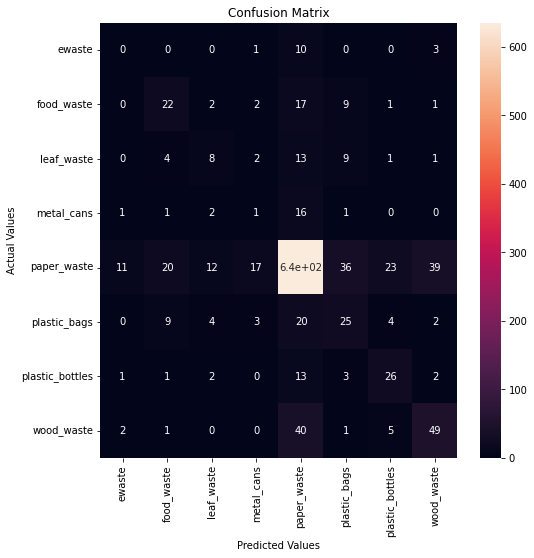

In [ ]:
print(metrics.classification_report(ytest, prediction))


from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, prediction)

cm_df = pd.DataFrame(cm,
                     index = ["ewaste", "food_waste", "leaf_waste", "metal_cans", "paper_waste", "plastic_bags", "plastic_bottles", "wood_waste"], 
                     columns = ["ewaste", "food_waste", "leaf_waste", "metal_cans", "paper_waste", "plastic_bags", "plastic_bottles", "wood_waste"])

#Plotting the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

## **Random Forest Classifier**

Random Forest is a classifier that contains a number of decision trees on various subsets of the given dataset and takes the average to improve the predictive accuracy of that dataset. It uses the concept of ensemble learning.

In [ ]:
rf=RandomForestClassifier(n_estimators= 100, criterion="entropy")

No. of tress in random forest used are 100 and criterion is taken as entropy as a part of information gain.

In [ ]:
rf.fit(xtrain,ytrain)

RandomForestClassifier(criterion='entropy')

In [ ]:
prediction = rf.predict(xtest)
accuracy = rf.score(xtest,ytest)

In [ ]:
print('Accuracy: ', accuracy)
print('Prediction: ', categories[prediction[0]])

Accuracy:  0.826278659611993
Prediction:  food_waste


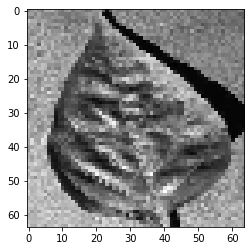

In [ ]:
waste = xtest[0].reshape(64,64)
plt.imshow(waste,cmap='gray')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.65      0.56      0.60        54
           2       0.62      0.26      0.37        38
           3       0.00      0.00      0.00        22
           4       0.83      0.98      0.90       793
           5       0.83      0.52      0.64        67
           6       0.93      0.58      0.72        48
           7       0.84      0.55      0.67        98

    accuracy                           0.83      1134
   macro avg       0.59      0.43      0.49      1134
weighted avg       0.80      0.83      0.80      1134



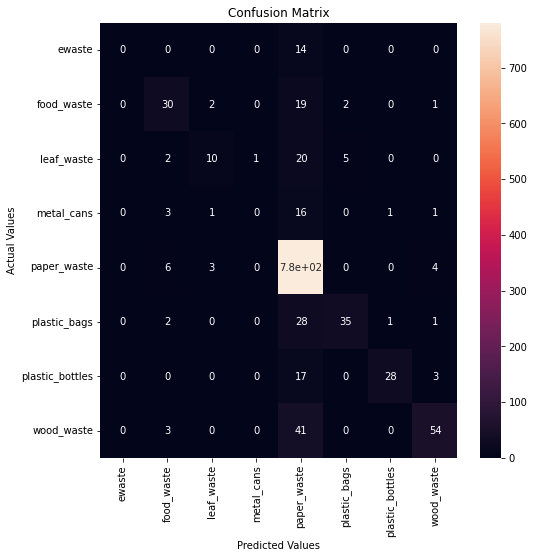

In [ ]:
print(metrics.classification_report(ytest, prediction))

cm = confusion_matrix(ytest, prediction)

cm_df = pd.DataFrame(cm,
                     index = ["ewaste", "food_waste", "leaf_waste", "metal_cans", "paper_waste", "plastic_bags", "plastic_bottles", "wood_waste"], 
                     columns = ["ewaste", "food_waste", "leaf_waste", "metal_cans", "paper_waste", "plastic_bags", "plastic_bottles", "wood_waste"])

#Plotting the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

**Oversampling data using Smote**

In [ ]:
#Oversampling using Smote
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
features, labels = sm.fit_resample(features, labels)

In [ ]:
# from imblearn.under_sampling import RandomUnderSampler
# strategy = {0:5000, 1:5000, 2:5000, 3:5000, 4:5000, 5:5000, 6:5000,7:5000}
# under = RandomUnderSampler(sampling_strategy=strategy)
# features, labels = under.fit_resample(features, labels)

In [ ]:
#Splitting the data into training and testing
xtrain, xtest,ytrain,ytest = train_test_split(features, labels, test_size = 0.08)

In [ ]:
#Converting the data into array for easy computation
xtrain = np.array(xtrain, dtype=np.float32)
xtest = np.array(xtest, dtype=np.float32)

In [ ]:
#Applying min-max normalization to rescale the images between 0 and 1
xtrain=xtrain/255
xtest=xtest/255

In [ ]:
print(len(xtrain))

74085


The length of the dataset is now 70,000 and all the classes are balanced

**SVM**

In [ ]:
svm = SVC(C=1, kernel = 'poly', gamma = 'auto')

In [ ]:
svm.fit(xtrain,ytrain)

In [ ]:
prediction = svm.predict(xtest)

In [ ]:
accuracy = svm.score(xtest,ytest)

**Naive Bayes Classifier**

In [ ]:
nb=GaussianNB()
nb.fit(xtrain,ytrain)

GaussianNB()

In [ ]:
prediction = nb.predict(xtest)
accuracy = nb.score(xtest,ytest)

In [ ]:
print('Accuracy: ', accuracy)
print('Prediction: ', categories[prediction[0]])

Accuracy:  0.27378550364736925
Prediction:  paper_waste


              precision    recall  f1-score   support

           0       0.32      0.60      0.42       785
           1       0.17      0.04      0.07       762
           2       0.26      0.45      0.33       816
           3       0.15      0.06      0.08       809
           4       0.46      0.22      0.30       793
           5       0.29      0.26      0.27       854
           6       0.19      0.17      0.18       766
           7       0.26      0.37      0.31       858

    accuracy                           0.27      6443
   macro avg       0.26      0.27      0.24      6443
weighted avg       0.26      0.27      0.25      6443



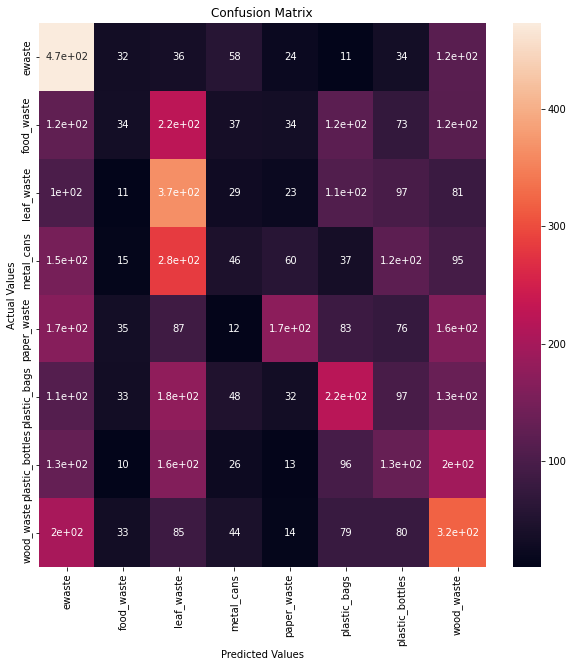

In [ ]:
from sklearn import metrics
import pandas as pd
print(metrics.classification_report(ytest, prediction))


from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, prediction)

cm_df = pd.DataFrame(cm,
                     index = ["ewaste", "food_waste", "leaf_waste", "metal_cans", "paper_waste", "plastic_bags", "plastic_bottles", "wood_waste"], 
                     columns = ["ewaste", "food_waste", "leaf_waste", "metal_cans", "paper_waste", "plastic_bags", "plastic_bottles", "wood_waste"])

#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

**Hyperparameter Tuning**

Var_smoothing (Variance smoothing) parameter specifies the portion of the largest variance of all features to be added to variances for stability of calculation.

Gaussian Naive Bayes assumes that features follows normal distribution which is most unlikely in real world.So solve this problem we can perform "power transformation" on each feature to make it more or less normally distributed. By default, PowerTransformer results in features that have a 0 mean and 1 standard deviation.

In [ ]:
np.logspace(0,-9, num=10)

array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07,
       1.e-08, 1.e-09])

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold

cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=999)

In [ ]:
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import GridSearchCV
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB = GridSearchCV(estimator=nb, 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')

Data_transformed = PowerTransformer().fit_transform(xtest)

gs_NB.fit(Data_transformed, ytest);

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


In [ ]:
gs_NB.best_params_

{'var_smoothing': 0.0001519911082952933}

In [ ]:
gs_NB.best_score_

0.27326638686641386

In [ ]:
results_NB = pd.DataFrame(gs_NB.cv_results_['params'])
results_NB['test_score'] = gs_NB.cv_results_['mean_test_score']

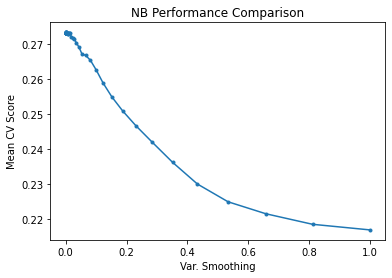

In [ ]:
plt.plot(results_NB['var_smoothing'], results_NB['test_score'], marker = '.')    
plt.xlabel('Var. Smoothing')
plt.ylabel("Mean CV Score")
plt.title("NB Performance Comparison")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
# predict the target on the test dataset
predict_test = gs_NB.predict(Data_transformed)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(ytest,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

accuracy_score on test dataset :  0.2807698277200062


Text(0.5, 1.0, 'Test Data')

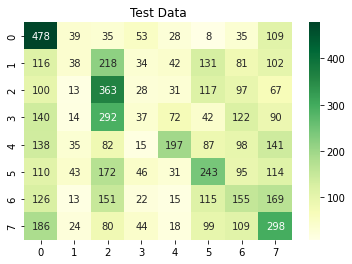

In [ ]:
sns.heatmap((metrics.confusion_matrix(ytest,predict_test)),annot=True,fmt='.5g',cmap="YlGn").set_title('Test Data')

**K Nearest Neighbour Classifier**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn

KNeighborsClassifier()

In [ ]:
# calculating the accuracy of models with different values of k
from sklearn import metrics
mean_acc = np.zeros(20)
for i in range(1,21):
    #Train Model and Predict  
    knn = KNeighborsClassifier(n_neighbors = i).fit(xtrain,ytrain)
    yhat= knn.predict(xtest)
    mean_acc[i-1] = metrics.accuracy_score(ytest, yhat)

mean_acc

array([0.83330747, 0.80893993, 0.76889648, 0.74949558, 0.71566041,
       0.70107093, 0.67065032, 0.65994102, 0.63588391, 0.62532982,
       0.60856744, 0.5970821 , 0.58497594, 0.57457706, 0.5668167 ,
       0.5581251 , 0.55020953, 0.54601894, 0.53701692, 0.53003259])

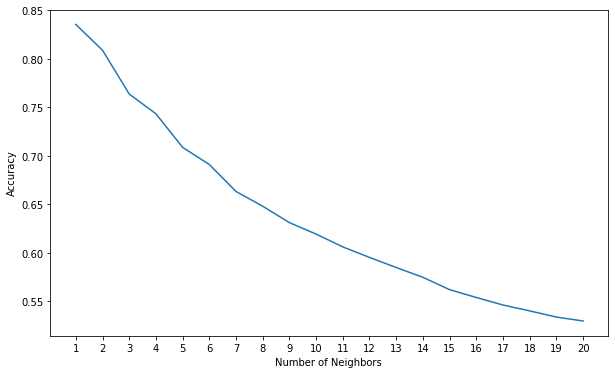

In [ ]:
loc = np.arange(1,21,step=1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1,21), mean_acc)
plt.xticks(loc)
plt.xlabel('Number of Neighbors ')
plt.ylabel('Accuracy')
plt.show()

**Hyperparameter Tuning**

We will use the Exhaustive Grid Search technique for hyperparameter optimization. An exhaustive grid search takes in as many hyperparameters as you would like, and tries every single possible combination of the hyperparameters as well as as many cross-validations as you would like it to perform. An exhaustive grid search is a good way to determine the best hyperparameter values to use, but it can quickly become time consuming with every additional parameter value and cross-validation that you add.

In [ ]:
from sklearn.model_selection import GridSearchCV

We will use three hyperparamters- n-neighbors, weights and metric.

n_neighbors: Decide the best k based on the values we have computed earlier.
weights: Check whether adding weights to the data points is beneficial to the model or not. 'uniform' assigns no weight, while 'distance' weighs points by the inverse of their distances meaning nearer points will have more weight than the farther points.
metric: The distance metric to be used will calculating the similarity.

In [ ]:
grid_params = { 'n_neighbors' : [3],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

In [ ]:
gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)

In [ ]:
# fit the model on our train set
g_res = gs.fit(xtrain, ytrain)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


KeyboardInterrupt: ignored

In [ ]:
# find the best score
g_res.best_score_

In [ ]:
# get the hyperparameters with the best score
g_res.best_params_

In [ ]:
prediction = g_res.predict(xtest)
accuracy = g_res.score(xtest,ytest)

In [ ]:
print('Accuracy: ', accuracy)
print('Prediction: ', categories[prediction[0]])

In [ ]:
from sklearn import metrics
import pandas as pd
print(metrics.classification_report(ytest, prediction))


from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, prediction)

cm_df = pd.DataFrame(cm,
                     index = ["ewaste", "food_waste", "leaf_waste", "metal_cans", "paper_waste", "plastic_bags", "plastic_bottles", "wood_waste"], 
                     columns = ["ewaste", "food_waste", "leaf_waste", "metal_cans", "paper_waste", "plastic_bags", "plastic_bottles", "wood_waste"])

#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

**Applying Decision Tree**

In [ ]:
dtc=DecisionTreeClassifier(criterion='gini', random_state=7)
dtc.fit(xtrain,ytrain)

DecisionTreeClassifier(random_state=7)

In [ ]:
prediction = dtc.predict(xtest)
accuracy_dtc = dtc.score(xtest,ytest)

In [ ]:
print('Accuracy: ', accuracy_dtc)
print('Prediction: ', categories[prediction[0]])

Accuracy:  0.6469036163277976
Prediction:  paper_waste


              precision    recall  f1-score   support

           0       0.85      0.85      0.85       779
           1       0.60      0.60      0.60       855
           2       0.63      0.68      0.65       793
           3       0.77      0.81      0.79       793
           4       0.46      0.41      0.43       795
           5       0.55      0.50      0.52       835
           6       0.66      0.68      0.67       803
           7       0.54      0.55      0.55       790

    accuracy                           0.64      6443
   macro avg       0.63      0.64      0.63      6443
weighted avg       0.63      0.64      0.63      6443



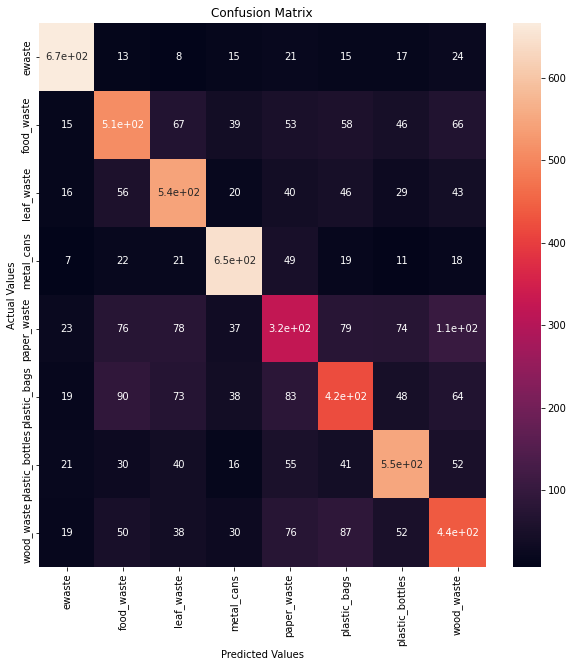

In [ ]:
from sklearn import metrics
import pandas as pd
print(metrics.classification_report(ytest, prediction))


from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, prediction)

cm_df = pd.DataFrame(cm,
                     index = ["ewaste", "food_waste", "leaf_waste", "metal_cans", "paper_waste", "plastic_bags", "plastic_bottles", "wood_waste"], 
                     columns = ["ewaste", "food_waste", "leaf_waste", "metal_cans", "paper_waste", "plastic_bags", "plastic_bottles", "wood_waste"])

#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

**Hyperparameter Tuning**

In [ ]:
dt = DecisionTreeClassifier(random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

In [ ]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [ ]:
%%time
grid_search.fit(xtrain, ytrain)

In [ ]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.head()

In [ ]:
score_df.nlargest(5,"mean_test_score")

In [ ]:
grid_search.best_estimator_

In [ ]:
dt_best = grid_search.best_estimator_

In [ ]:
def evaluate_model(dt_classifier):
    print("Train Accuracy :", accuracy_score(ytrain, dt_classifier.predict(xtrain)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(ytrain, dt_classifier.predict(xtrain)))
    print("-"*50)
    print("Test Accuracy :", accuracy_score(ytest, dt_classifier.predict(xtest)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(ytest, dt_classifier.predict(xtest)))

In [ ]:
prediction = dt_best.predict(xtest)
accuracy = dt_best.score(xtest,ytest)

In [ ]:
from sklearn import metrics
import pandas as pd
print(metrics.classification_report(ytest, prediction))


from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, prediction)

cm_df = pd.DataFrame(cm,
                     index = ["ewaste", "food_waste", "leaf_waste", "metal_cans", "paper_waste", "plastic_bags", "plastic_bottles", "wood_waste"], 
                     columns = ["ewaste", "food_waste", "leaf_waste", "metal_cans", "paper_waste", "plastic_bags", "plastic_bottles", "wood_waste"])

#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()


**Ensemble Learning**

**Applying Random Forest**

In [ ]:
rf=RandomForestClassifier(n_estimators= 100, criterion="entropy")

In [ ]:
rf.fit(xtrain,ytrain)

RandomForestClassifier(criterion='entropy')

In [ ]:
prediction = rf.predict(xtest)
accuracy = rf.score(xtest,ytest)

In [ ]:
print('Accuracy: ', accuracy)
print('Prediction: ', categories[prediction[0]])

Accuracy:  0.8935278596926898
Prediction:  food_waste


The accuracy obtained using random forest classifier is 89% which is better than the previous value 83%

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       833
           1       0.87      0.87      0.87       784
           2       0.96      0.89      0.92       866
           3       0.99      0.98      0.99       780
           4       0.72      0.81      0.77       787
           5       0.83      0.84      0.83       789
           6       0.94      0.92      0.93       800
           7       0.88      0.85      0.87       804

    accuracy                           0.89      6443
   macro avg       0.90      0.89      0.89      6443
weighted avg       0.90      0.89      0.89      6443



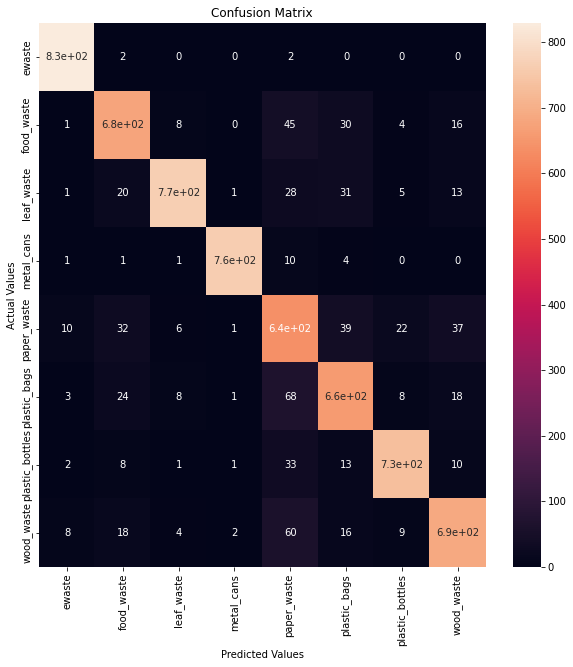

In [ ]:
from sklearn import metrics
print(metrics.classification_report(ytest, prediction))
import pandas as pd

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, prediction)

cm_df = pd.DataFrame(cm,
                     index = ["ewaste", "food_waste", "leaf_waste", "metal_cans", "paper_waste", "plastic_bags", "plastic_bottles", "wood_waste"], 
                     columns = ["ewaste", "food_waste", "leaf_waste", "metal_cans", "paper_waste", "plastic_bags", "plastic_bottles", "wood_waste"])

#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

**Hyperparameter Tuning Using RandomSearch CV**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in range(200,2000,200)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(xtrain, ytrain)

NameError: ignored

In [ ]:
rf_random.best_params_


In [ ]:
from sklearn import metrics

def evaluate(model, test_features, test_labels):
    y_pred = model.predict(test_features)
    accuracy = metrics.accuracy_score(ytest, y_pred)
    print (accuracy)
    print(confusion_matrix(ytest,y_pred))
    

best_random = rf_random.best_estimator_
evaluate(best_random, xtest, ytest)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10,15],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5,6],
    'min_samples_split': [3,4,5,6],
    'n_estimators': [1150, 1200, 1250, 1300,1350]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(xtrain,ytrain)

In [ ]:
grid_search.best_params_

In [ ]:
best_grid = grid_search.best_estimator_
evaluate(best_grid,xtest,ytest)

**Bagging Classifier**

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
bagging_clf = BaggingClassifier(base_estimator=tree, n_estimators=1000, random_state=42)
bagging_clf.fit(xtrain, ytrain)


In [ ]:
prediction = bagging_clf.predict(xtest)
accuracy = bagging_clf.score(xtest,ytest)

In [ ]:
from sklearn import metrics
print(metrics.classification_report(ytest, prediction))
import pandas as pd

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, prediction)

cm_df = pd.DataFrame(cm,
                     index = ["ewaste", "food_waste", "leaf_waste", "metal_cans", "paper_waste", "plastic_bags", "plastic_bottles", "wood_waste"], 
                     columns = ["ewaste", "food_waste", "leaf_waste", "metal_cans", "paper_waste", "plastic_bags", "plastic_bottles", "wood_waste"])

#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

**ExtraTrees Classifier**

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

ex_tree_clf = ExtraTreesClassifier(n_estimators=1000, max_features=7, random_state=42)
ex_tree_clf.fit(xtrain, ytrain)


ExtraTreesClassifier(max_features=7, n_estimators=1000, random_state=42)

In [ ]:
prediction = ex_tree_clf.predict(xtest)
accuracy = ex_tree_clf.score(xtest,ytest)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       813
           1       0.91      0.89      0.90       810
           2       0.99      0.88      0.93       801
           3       1.00      0.98      0.99       785
           4       0.72      0.85      0.78       852
           5       0.90      0.86      0.88       787
           6       0.94      0.94      0.94       836
           7       0.86      0.84      0.85       759

    accuracy                           0.91      6443
   macro avg       0.91      0.91      0.91      6443
weighted avg       0.91      0.91      0.91      6443



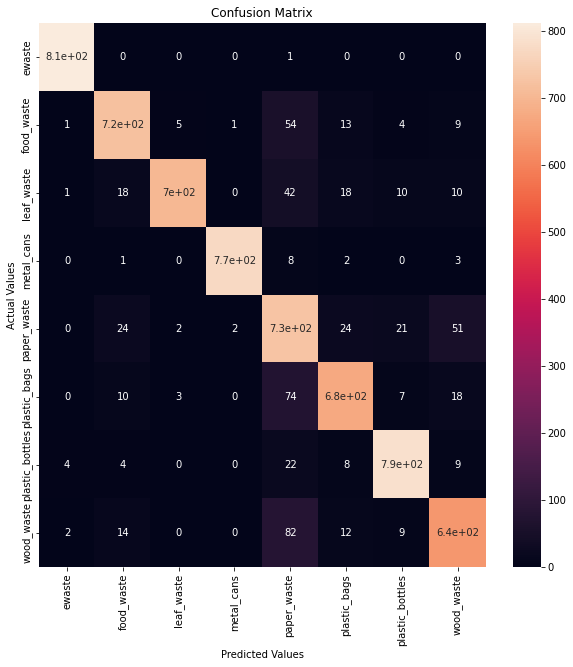

In [ ]:
from sklearn import metrics
print(metrics.classification_report(ytest, prediction))
import pandas as pd

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, prediction)

cm_df = pd.DataFrame(cm,
                     index = ["ewaste", "food_waste", "leaf_waste", "metal_cans", "paper_waste", "plastic_bags", "plastic_bottles", "wood_waste"], 
                     columns = ["ewaste", "food_waste", "leaf_waste", "metal_cans", "paper_waste", "plastic_bags", "plastic_bottles", "wood_waste"])

#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

The best metrics are shown by ExtraTrees Classifier in Ensemble Learning

**AdaBoost Classifier**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_boost_clf = AdaBoostClassifier(n_estimators=30)
ada_boost_clf.fit(xtrain, ytrain)

AdaBoostClassifier(n_estimators=30)

In [ ]:
prediction = ada_boost_clf.predict(xtest)
accuracy = ada_boost_clf.score(xtest,ytest)

              precision    recall  f1-score   support

           0       0.32      0.61      0.42       809
           1       0.14      0.08      0.10       826
           2       0.41      0.17      0.24       779
           3       0.46      0.29      0.35       843
           4       0.36      0.31      0.33       809
           5       0.20      0.36      0.26       773
           6       0.17      0.15      0.16       788
           7       0.28      0.30      0.29       816

    accuracy                           0.28      6443
   macro avg       0.29      0.28      0.27      6443
weighted avg       0.29      0.28      0.27      6443



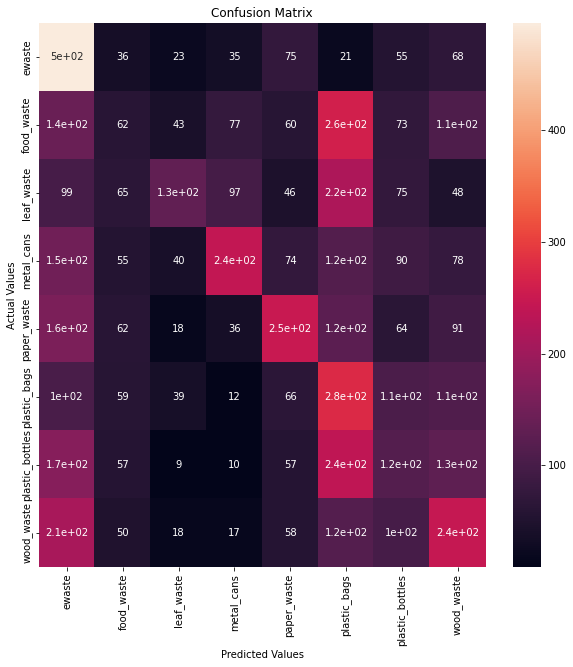

In [ ]:
from sklearn import metrics
print(metrics.classification_report(ytest, prediction))
import pandas as pd

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, prediction)

cm_df = pd.DataFrame(cm,
                     index = ["ewaste", "food_waste", "leaf_waste", "metal_cans", "paper_waste", "plastic_bags", "plastic_bottles", "wood_waste"], 
                     columns = ["ewaste", "food_waste", "leaf_waste", "metal_cans", "paper_waste", "plastic_bags", "plastic_bottles", "wood_waste"])

#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

**Gradient Boosting Classifier**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
grad_boost_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
grad_boost_clf.fit(xtrain, ytrain)

In [ ]:
prediction = grad_boost_clf.predict(xtest)
accuracy = grad_boost_clf.score(xtest,ytest)

In [ ]:
from sklearn import metrics
print(metrics.classification_report(ytest, prediction))
import pandas as pd

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, prediction)

cm_df = pd.DataFrame(cm,
                     index = ["ewaste", "food_waste", "leaf_waste", "metal_cans", "paper_waste", "plastic_bags", "plastic_bottles", "wood_waste"], 
                     columns = ["ewaste", "food_waste", "leaf_waste", "metal_cans", "paper_waste", "plastic_bags", "plastic_bottles", "wood_waste"])

#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

**AUC ROC Curve**

In [ ]:
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score



In [ ]:
# classifier = OneVsRestClassifier(
#     svm.SVC(kernel="linear", probability=True, random_state=0)
# )
# y_score = classifier.fit(xtrain, ytrain).decision_function(xtest)
#Calculate the y_score
y_score = ex_tree_clf.predict_proba(xtest)

In [ ]:
print(y_score)
y_score_list = np.array(y_score)
print(y_score_list)

[[0.062 0.082 0.521 ... 0.074 0.048 0.078]
 [0.013 0.044 0.042 ... 0.074 0.086 0.042]
 [0.715 0.035 0.026 ... 0.046 0.039 0.048]
 ...
 [0.003 0.253 0.357 ... 0.032 0.014 0.026]
 [0.983 0.002 0.001 ... 0.004 0.003 0.004]
 [0.005 0.029 0.028 ... 0.047 0.786 0.075]]
[[0.062 0.082 0.521 ... 0.074 0.048 0.078]
 [0.013 0.044 0.042 ... 0.074 0.086 0.042]
 [0.715 0.035 0.026 ... 0.046 0.039 0.048]
 ...
 [0.003 0.253 0.357 ... 0.032 0.014 0.026]
 [0.983 0.002 0.001 ... 0.004 0.003 0.004]
 [0.005 0.029 0.028 ... 0.047 0.786 0.075]]


In [ ]:
#Binarize the output
y_test_bin = label_binarize(ytest, classes=[0, 1, 2, 3, 4, 5, 6,7])
n_classes = y_test_bin.shape[1]

In [ ]:
print(y_test_bin)
y_test_bin_l = np.array(y_test_bin)

[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]


AUC for Class 1: 0.9999569604932285
AUC for Class 2: 0.9905136836937535
AUC for Class 3: 0.9949667444230692
AUC for Class 4: 0.9997199163351368
AUC for Class 5: 0.9702829749018165
AUC for Class 6: 0.9845818229036554
AUC for Class 7: 0.9950696028460666
AUC for Class 8: 0.9812659764737298


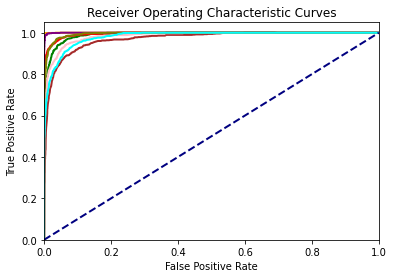

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
color = ['orange','green','red','purple','brown','pink','olive','cyan']
for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin_l[:, i], y_score_list[:, i])
  plt.plot(fpr[i], tpr[i], color=color[i], lw=2)
  print('AUC for Class {}: {}'.format(i+1, auc(fpr[i], tpr[i])))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curves')
plt.show()

In [ ]:
macro_roc_auc_ovr = roc_auc_score(ytest, y_score_list, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(
    ytest, y_score_list, multi_class="ovr", average="weighted"
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)

One-vs-Rest ROC AUC scores:
0.989545 (macro),
0.989482 (weighted by prevalence)


 **CNN Classifier** 

Converting the dataset into 3x3 matrix using ImageDataGenerator from tensorflow library

In [ ]:
train = '/tmp/Dataset/train/'
val = '/tmp/Dataset/val/'

In [ ]:
IMAGE_SIZE=224
BATCH_SIZE=64

#pre=processing
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    
    )


val_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_datagen=train_datagen.flow_from_directory(
    train,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode = 'categorical'
)


val_datagen=val_datagen.flow_from_directory(
    '/tmp/Dataset/val/',
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode = 'categorical'
)

Found 14165 images belonging to 8 classes.
Found 1201 images belonging to 8 classes.


The Convolutional Layer uses first 64 and then 32 filters with a 3×3 kernel as a filter and the Max Pooling Layer searches for the maximum value within a 2×2 matrix.

In [ ]:
cnn=tf.keras.Sequential()
#1st layer
cnn.add(tf.keras.layers.Conv2D(filters=64,padding='same',strides=2,kernel_size=3,activation='relu',input_shape=(224,224,3)))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))
#2nd layer
cnn.add(tf.keras.layers.Conv2D(filters=32,padding='same',strides=2,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))
#3rd layer
cnn.add(tf.keras.layers.Conv2D(filters=32,padding='same',strides=2,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2))

cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(8,activation='softmax'))

In [ ]:
cnn.compile(optimizer=tf.keras.optimizers.Adam(),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
result = cnn.fit(train_datagen,epochs=20,validation_data=val_datagen)

Epoch 1/20
 98/222 [============>.................] - ETA: 4:39 - loss: 1.0211 - accuracy: 0.7097

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


222/222 [==============================] - 508s 2s/step - loss: 0.8468 - accuracy: 0.7476 - val_loss: 1.3814 - val_accuracy: 0.5662
Epoch 2/20
222/222 [==============================] - 495s 2s/step - loss: 0.5547 - accuracy: 0.8281 - val_loss: 1.0669 - val_accuracy: 0.6261
Epoch 3/20
222/222 [==============================] - 497s 2s/step - loss: 0.4686 - accuracy: 0.8482 - val_loss: 1.1130 - val_accuracy: 0.6395
Epoch 4/20
222/222 [==============================] - 487s 2s/step - loss: 0.4399 - accuracy: 0.8563 - val_loss: 0.9186 - val_accuracy: 0.6819
Epoch 5/20
222/222 [==============================] - 483s 2s/step - loss: 0.4159 - accuracy: 0.8621 - val_loss: 0.9822 - val_accuracy: 0.6603
Epoch 6/20
222/222 [==============================] - 481s 2s/step - loss: 0.3898 - accuracy: 0.8705 - val_loss: 0.9456 - val_accuracy: 0.6719
Epoch 7/20
222/222 [==============================] - 477s 2s/step - loss: 0.3802 - accuracy: 0.8702 - val_loss: 1.0542 - val_accuracy: 0.6761
Epoch 8/20

In [ ]:
# Create the Fast Gradient Method (FGM) attack
attack = FastGradientMethod(estimator=art_classifier, eps=0.1)

# Generate adversarial examples
x_valid_adv = attack.generate(x=valid_gen)

NameError: ignored

The training accuracy obtained at the last epoch is 90% with a loss of 0.27 whereas the validation accuracy is 71% with a loss of 0.73.

In [ ]:
#Determining  accuracy of test image
from tensorflow.keras.preprocessing import image
output_class = ["ewaste", "food_waste", "leaf_waste", "metal_cans", "paper_waste", "plastic_bags", "plastic_bottles", "wood_waste"]
def waste_prediction(new_image):
  test_image = image.load_img(new_image, target_size = (224,224))
  
  plt.axis("off")
  plt.imshow(test_image) #Displaying test image
  plt.show()
 
  test_image = image.img_to_array(test_image) / 255
  test_image = np.expand_dims(test_image, axis=0)

  predicted_array = cnn.predict(test_image)#Predicting accuracy of test image
  predicted_value = output_class[np.argmax(predicted_array)]
  predicted_accuracy = round(np.max(predicted_array) * 100, 2)

  print("Your waste material is ", predicted_value, " with ", predicted_accuracy, " % accuracy")

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


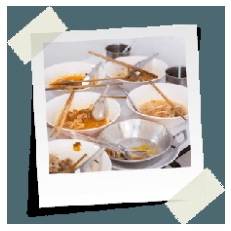

1/1 [==============================] - 0s 30ms/step
Your waste material is  food_waste  with  98.61  % accuracy


In [ ]:

waste_prediction('/content/00000367.jpg')

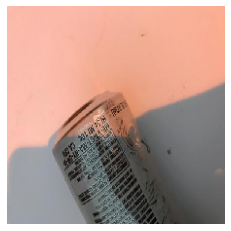

1/1 [==============================] - 0s 33ms/step
Your waste material is  metal_cans  with  58.6  % accuracy


In [ ]:
waste_prediction('/content/metal403.jpg')

We are getting different accuracies for different kinds of waste as cnn has been performed on an imbalanced dataset and due to overfitting the accuracy reduces.

In [ ]:
#Plotting training accuracy curve
plt.title("Accuracy")
plt.plot(result.history["accuracy"])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
#Plotting loss curve
plt.title("Loss")
plt.plot(result.history["loss"])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
#Plotting loss vs epoch curve fror training and validation loss
loss_train = result.history['loss']
loss_val = result.history['val_loss']
epochs = range(0,20)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

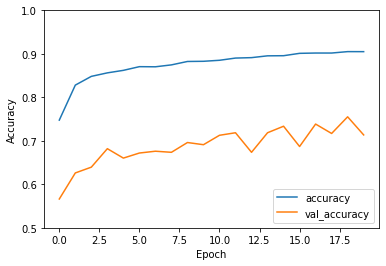

In [ ]:
#Plotting accuracy vs epoch curve fror training and validation accuracy
loss_train = result.history['accuracy']
loss_val = result.history['val_accuracy']
epochs = range(0,20)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()